# CNN-MLP Multimodal Composer Classification

This notebook contains the CNN-MLP fusion model architecture and training pipeline for composer classification.

## Model Architecture
- **CNN Stream**: Processes piano roll data for visual pattern recognition
- **MLP Stream**: Processes hand-crafted musical features
- **Fusion Layer**: Combines both streams for final classification

In [4]:
%pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 89.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=b1749eaff8b99bb58cfcccc8eb0d3253865bf586e5a7390b6681ff435db5abd2
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import pickle

In [ ]:
import importlib
import utils

importlib.reload(utils)

from utils import *

print("🔧 Utils and dependencies imported")
device = get_device()

🔧 Utils and dependencies imported
🚀 Using CUDA GPU: NVIDIA A100-SXM4-40GB


In [6]:
# download dataset
paths = download_dataset()

Dataset downloaded and extracted to data/kaggle/midiclassics


In [ ]:
class MultimodalComposerClassifier(nn.Module):
    """
    Multimodal architecture combining CNN (piano rolls) + MLP (musical features)
    """
    def __init__(self, num_classes=4, num_features=None):
        super(MultimodalComposerClassifier, self).__init__()

        # CNN Stream for Piano Rolls (visual patterns)
        self.cnn_stream = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=(2, 2)),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=(2, 2)),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(kernel_size=(2, 2)),

            # Global pooling instead of LSTM
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

        # MLP Stream for Musical Features (hand-crafted features)
        self.mlp_stream = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Fusion Layer (combine both streams)
        self.fusion = nn.Sequential(
            nn.Linear(128 + 32, 256),  # 128 from CNN + 32 from MLP
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, piano_roll, features):
        cnn_features = self.cnn_stream(piano_roll) # piano rolls go through CNN
        mlp_features = self.mlp_stream(features) # hand-crafted features go through MLP
        combined = torch.cat([cnn_features, mlp_features], dim=1) # we put the outputs together for multimodality
        output = self.fusion(combined) # Now, we fuse the two streams into a final layer and classify
        return output

🏗️ CNN-MLP Model Architecture Defined!
• CNN Stream: Processes piano roll visual patterns
• MLP Stream: Processes hand-crafted musical features
• Fusion Layer: Combines both streams for classification


In [ ]:
def train_cnn_mlp_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=40, device='cpu'):
    """
    Train the CNN-MLP multimodal model

    Args:
        model: CNN-MLP model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        epochs (int): Number of epochs to train
        device (str): Device to train on

    Returns:
        tuple: (train_losses, val_accuracies)
    """
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0.0

        for piano_rolls, features, labels in train_loader:
            piano_rolls, features, labels = piano_rolls.to(device), features.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(piano_rolls, features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for piano_rolls, features, labels in val_loader:
                piano_rolls, features, labels = piano_rolls.to(device), features.to(device), labels.to(device)
                outputs = model(piano_rolls, features)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        avg_loss = epoch_loss / len(train_loader)

        train_losses.append(avg_loss)
        val_accuracies.append(val_accuracy)

        print(f'[CNN-MLP] Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        scheduler.step()

    return train_losses, val_accuracies

print("CNN-MLP training function defined")

✅ CNN-MLP training function defined


In [9]:
TARGET_COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

In [10]:
data, labels, features, song_ids = load_segmented_dataset_no_overlap(paths["extract_path"], TARGET_COMPOSERS)

🎵 LOADING DATASET WITH NON-OVERLAPPING SEGMENTATION...
Segment duration: 20.0s with NO OVERLAP
Balance classes: True

--- Processing Bach ---
  Processed 10 files, created 192 segments...
  Processed 20 files, created 331 segments...


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


  Processed 30 files, created 486 segments...
  Processed 40 files, created 610 segments...
  Processed 50 files, created 735 segments...
  Processed 60 files, created 898 segments...
  Processed 70 files, created 1110 segments...
  Processed 80 files, created 1287 segments...
  Processed 90 files, created 1522 segments...
  Processed 100 files, created 1684 segments...
  Processed 110 files, created 1891 segments...
  Processed 120 files, created 2049 segments...
  Processed 130 files, created 2270 segments...
✅ Bach: 131 files → 2276 segments

--- Processing Beethoven ---
  Processed 10 files, created 268 segments...
  Processed 20 files, created 444 segments...
  Processed 30 files, created 584 segments...
  Processed 40 files, created 757 segments...
  Processed 50 files, created 887 segments...
  Processed 60 files, created 1117 segments...
  Processed 70 files, created 1304 segments...
Error processing data/kaggle/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode key with 

In [11]:
song_ids[0:5]

['data/kaggle/midiclassics/Bach/Bwv0916 Toccata.MID__0',
 'data/kaggle/midiclassics/Bach/Bwv0916 Toccata.MID__1',
 'data/kaggle/midiclassics/Bach/Bwv0916 Toccata.MID__2',
 'data/kaggle/midiclassics/Bach/Bwv0916 Toccata.MID__3',
 'data/kaggle/midiclassics/Bach/Bwv0916 Toccata.MID__4']

In [12]:
comprehensive_features = load_comprehensive_features(data)

✅ Saved comprehensive_features to cache: local_cache/comprehensive_musical_features.pkl


In [13]:
num_classes = len(TARGET_COMPOSERS)
num_features = len(comprehensive_features[0])

num_classes, num_features

(4, 30)

In [14]:
model = MultimodalComposerClassifier(num_classes=num_classes, num_features=num_features).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

In [15]:
train_loader, val_loader = create_songwise_data_loaders(
    data,
    labels,
    comprehensive_features,
    song_ids,
    batch_size=32,
    train_split=0.8,
    dataset_class=MultimodalDataset
)

📊 Feature Processing:
• Feature names: ['avg_notes_per_time', 'note_density_variance', 'note_density_std', 'max_simultaneous_notes', 'onset_density']...
• Features normalized: mean≈0, std≈1
✅ Multimodal Dataset Created:
• Piano rolls: torch.Size([7305, 128, 2000])
• Features: torch.Size([7305, 30])
• Labels: torch.Size([7305])
• Total samples: 7305
📊 Feature Processing:
• Feature names: ['avg_notes_per_time', 'note_density_variance', 'note_density_std', 'max_simultaneous_notes', 'onset_density']...
• Features normalized: mean≈0, std≈1
✅ Multimodal Dataset Created:
• Piano rolls: torch.Size([1827, 128, 2000])
• Features: torch.Size([1827, 30])
• Labels: torch.Size([1827])
• Total samples: 1827
📊 Songwise Data Loaders Created:
• Training samples: 7305
• Validation samples: 1827
• Batch size: 32


In [16]:
EPOCHS = 40
train_losses, val_accuracies = train_cnn_mlp_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs=EPOCHS,
    device=device
)

[CNN-MLP] Epoch [1/40], Loss: 1.0743, Val Acc: 65.79%
[CNN-MLP] Epoch [2/40], Loss: 0.8239, Val Acc: 72.19%
[CNN-MLP] Epoch [3/40], Loss: 0.7424, Val Acc: 74.82%
[CNN-MLP] Epoch [4/40], Loss: 0.6899, Val Acc: 77.94%
[CNN-MLP] Epoch [5/40], Loss: 0.6579, Val Acc: 78.98%
[CNN-MLP] Epoch [6/40], Loss: 0.6186, Val Acc: 81.39%
[CNN-MLP] Epoch [7/40], Loss: 0.5987, Val Acc: 82.87%
[CNN-MLP] Epoch [8/40], Loss: 0.5794, Val Acc: 82.70%
[CNN-MLP] Epoch [9/40], Loss: 0.5596, Val Acc: 83.31%
[CNN-MLP] Epoch [10/40], Loss: 0.5407, Val Acc: 83.80%
[CNN-MLP] Epoch [11/40], Loss: 0.5136, Val Acc: 84.78%
[CNN-MLP] Epoch [12/40], Loss: 0.4955, Val Acc: 85.06%
[CNN-MLP] Epoch [13/40], Loss: 0.4953, Val Acc: 85.11%
[CNN-MLP] Epoch [14/40], Loss: 0.4785, Val Acc: 86.43%
[CNN-MLP] Epoch [15/40], Loss: 0.4628, Val Acc: 87.19%
[CNN-MLP] Epoch [16/40], Loss: 0.4463, Val Acc: 86.81%
[CNN-MLP] Epoch [17/40], Loss: 0.4473, Val Acc: 86.86%
[CNN-MLP] Epoch [18/40], Loss: 0.4354, Val Acc: 87.41%
[CNN-MLP] Epoch [19

🔍 EVALUATING MODEL...

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Bach     0.9491    0.9147    0.9316       469
   Beethoven     0.8684    0.8665    0.8675       457
      Chopin     0.9342    0.9537    0.9439       432
      Mozart     0.8933    0.9104    0.9018       469

    accuracy                         0.9108      1827
   macro avg     0.9113    0.9113    0.9112      1827
weighted avg     0.9111    0.9108    0.9108      1827



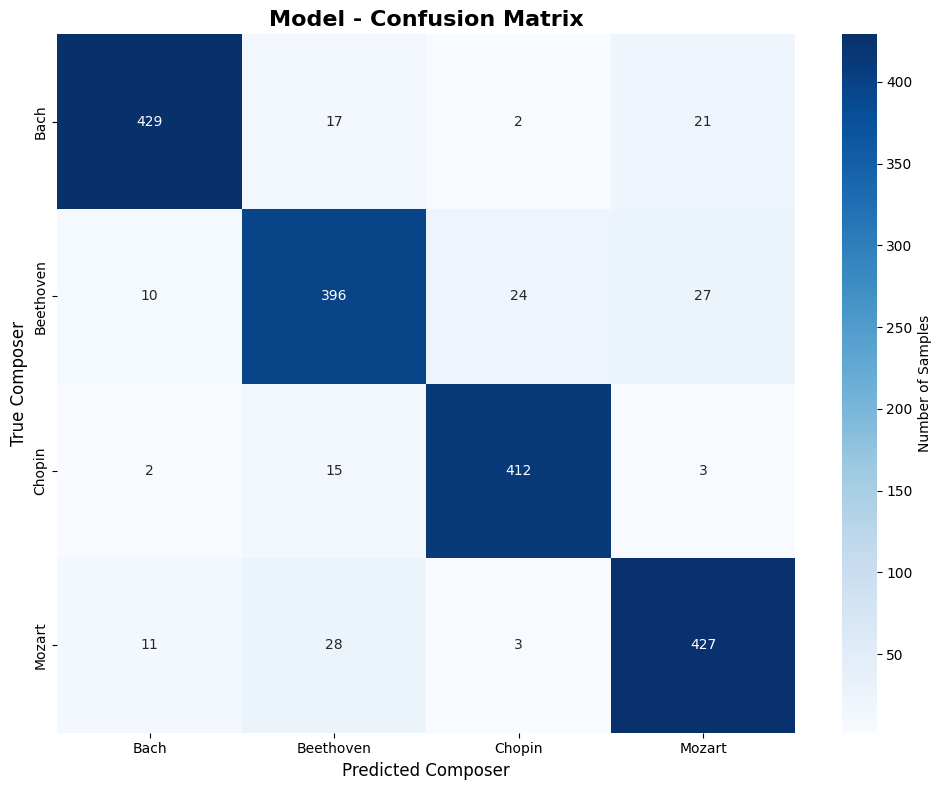


🎯 PER-CLASS ACCURACY:
Bach        : 0.9147 (91.47%)
Beethoven   : 0.8665 (86.65%)
Chopin      : 0.9537 (95.37%)
Mozart      : 0.9104 (91.04%)

🏆 OVERALL ACCURACY: 0.9108 (91.08%)

❌ MOST CONFUSED PAIRS:
Mozart → Beethoven: 28 samples
Beethoven → Mozart: 27 samples
Beethoven → Chopin: 24 samples
Bach → Mozart: 21 samples
Bach → Beethoven: 17 samples


In [17]:
results = evaluate_model_comprehensive(model, val_loader, TARGET_COMPOSERS, device)

In [ ]:
# Create the directory if it doesn't exist
save_dir = '../saved_models'
os.makedirs(save_dir, exist_ok=True)

# Save the model
torch.save(model.state_dict(), os.path.join(save_dir, 'cnn_mlp_composer_classifier.pth'))
print(f"Model saved to {save_dir}!")

✅ Model saved to saved_models!
